# Two-Asset Portfolio Analysis
This notebook demonstrates how combining two assets in different proportions affects portfolio risk and return.

## Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns


## Data Collection
Let's create functions to fetch and process our data:

In [2]:
def get_stock_data(ticker1, ticker2, start_date='2020-01-01', end_date='2023-12-31'):
    """
    Fetches monthly returns for two stocks
    """
    # Download data for both stocks
    stock1 = yf.download(ticker1, start=start_date,
                         end=end_date, progress=False)
    stock2 = yf.download(ticker2, start=start_date,
                         end=end_date, progress=False)

    # Calculate monthly returns
    returns1 = stock1['Close'].resample('ME').last().pct_change()
    returns2 = stock2['Close'].resample('ME').last().pct_change()

    # Combine into a DataFrame
    returns_df = pd.DataFrame({
        ticker1: returns1[ticker1],
        ticker2: returns2[ticker2]
    }, index=returns1[ticker1].index)
    return returns_df.dropna()


# Example usage
ticker1, ticker2 = 'AAPL', 'JNJ'  # Technology vs Healthcare
returns_df = get_stock_data(ticker1, ticker2)

## Calculate Portfolio Metrics
Let's create functions to calculate portfolio return, risk, and other metrics:


In [3]:
def calculate_portfolio_metrics(returns_df, weights):
    """
    Calculates portfolio return and risk for given weights
    """
    # Calculate expected returns (annualized)
    returns = returns_df.mean() * 12
    portfolio_return = np.sum(returns * weights)

    # Calculate portfolio risk (annualized)
    cov_matrix = returns_df.cov() * 12
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Calculate correlation
    correlation = returns_df.corr().iloc[0, 1]

    return portfolio_return, portfolio_risk, correlation


# Calculate metrics for equal weights
weights = np.array([0.5, 0.5])
port_return, port_risk, correlation = calculate_portfolio_metrics(
    returns_df, weights)

print(f"Portfolio Metrics (Equal Weights):")
print(f"Expected Return: {port_return*100:.2f}%")
print(f"Risk (Standard Deviation): {port_risk*100:.2f}%")
print(f"Correlation: {correlation:.2f}")

Portfolio Metrics (Equal Weights):
Expected Return: 17.24%
Risk (Standard Deviation): 21.05%
Correlation: 0.42



## Generate Efficient Frontier
Let's plot different portfolio combinations:

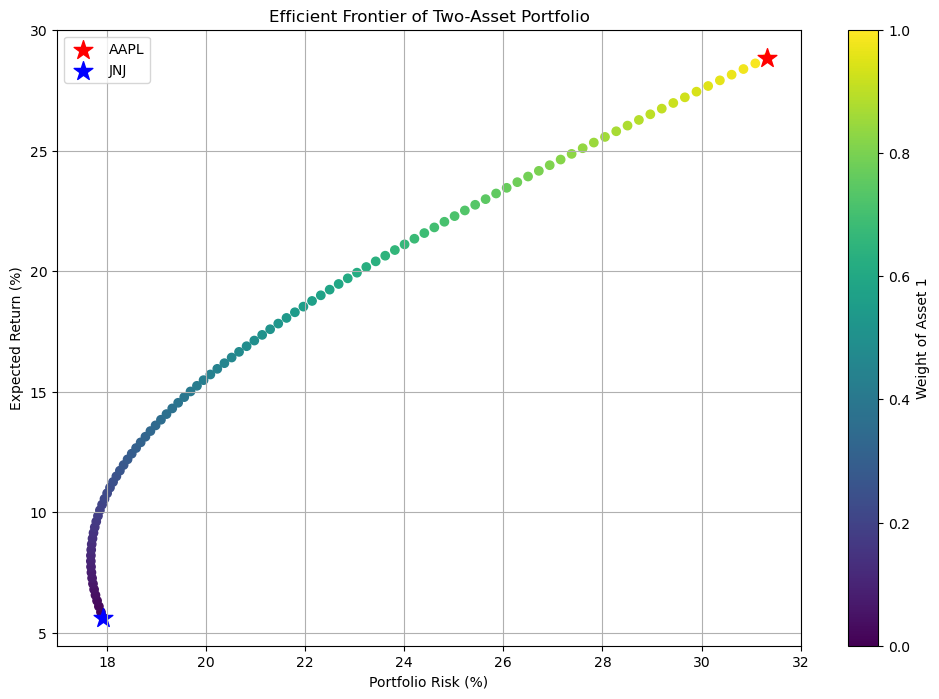

In [4]:
def generate_efficient_frontier(returns_df, num_portfolios=100):
    """
    Generates points along the efficient frontier
    """
    # Arrays to store returns and volatilities
    portfolio_returns = []
    portfolio_risks = []
    portfolio_weights = []

    for i in range(num_portfolios):
        # Generate random weights
        weight = i / (num_portfolios - 1)
        weights = np.array([weight, 1-weight])

        # Calculate portfolio metrics
        port_return, port_risk, _ = calculate_portfolio_metrics(
            returns_df, weights)

        # Store results
        portfolio_returns.append(port_return)
        portfolio_risks.append(port_risk)
        portfolio_weights.append(weights[0])

    return np.array(portfolio_returns), np.array(portfolio_risks), np.array(portfolio_weights)


# Generate and plot efficient frontier
returns, risks, weights = generate_efficient_frontier(returns_df)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(risks*100, returns*100, c=weights, cmap='viridis')
plt.colorbar(scatter, label='Weight of Asset 1')

# Plot individual assets
asset1_return = returns_df[ticker1].mean() * 12
asset1_risk = returns_df[ticker1].std() * np.sqrt(12)
asset2_return = returns_df[ticker2].mean() * 12
asset2_risk = returns_df[ticker2].std() * np.sqrt(12)

plt.scatter([asset1_risk*100], [asset1_return*100],
            color='red', marker='*', s=200, label=ticker1)
plt.scatter([asset2_risk*100], [asset2_return*100],
            color='blue', marker='*', s=200, label=ticker2)

plt.xlabel('Portfolio Risk (%)')
plt.ylabel('Expected Return (%)')
plt.title('Efficient Frontier of Two-Asset Portfolio')
plt.legend()
plt.grid(True)
plt.show()


## Analyze Optimal Portfolios
Let's find and analyze some key portfolio combinations:


In [5]:
def find_optimal_portfolios(returns_df, rf_rate=0.03):
    """
    Finds minimum variance and maximum Sharpe ratio portfolios
    """
    returns, risks, weights = generate_efficient_frontier(
        returns_df, num_portfolios=1000)

    # Find minimum variance portfolio
    min_var_idx = np.argmin(risks)
    min_var_return = returns[min_var_idx]
    min_var_risk = risks[min_var_idx]
    min_var_weight = weights[min_var_idx]

    # Find maximum Sharpe ratio portfolio
    sharpe_ratios = (returns - rf_rate) / risks
    max_sharpe_idx = np.argmax(sharpe_ratios)
    max_sharpe_return = returns[max_sharpe_idx]
    max_sharpe_risk = risks[max_sharpe_idx]
    max_sharpe_weight = weights[max_sharpe_idx]

    return {
        'Minimum Variance': {
            'weight1': min_var_weight,
            'weight2': 1 - min_var_weight,
            'return': min_var_return,
            'risk': min_var_risk
        },
        'Maximum Sharpe': {
            'weight1': max_sharpe_weight,
            'weight2': 1 - max_sharpe_weight,
            'return': max_sharpe_return,
            'risk': max_sharpe_risk
        }
    }


# Find optimal portfolios
optimal_portfolios = find_optimal_portfolios(returns_df)

# Print results
print("\nOptimal Portfolios:")
for portfolio_type, metrics in optimal_portfolios.items():
    print(f"\n{portfolio_type} Portfolio:")
    print(f"{ticker1} Weight: {metrics['weight1']*100:.1f}%")
    print(f"{ticker2} Weight: {metrics['weight2']*100:.1f}%")
    print(f"Expected Return: {metrics['return']*100:.2f}%")
    print(f"Risk: {metrics['risk']*100:.2f}%")


Optimal Portfolios:

Minimum Variance Portfolio:
AAPL Weight: 10.3%
JNJ Weight: 89.7%
Expected Return: 8.02%
Risk: 17.68%

Maximum Sharpe Portfolio:
AAPL Weight: 100.0%
JNJ Weight: 0.0%
Expected Return: 28.87%
Risk: 31.32%


## Interactive Analysis
Let's create a function to analyze any weight combination:


In [6]:
def analyze_portfolio_weight(returns_df, weight1):
    """
    Analyzes portfolio metrics for a given weight combination
    """
    weights = np.array([weight1, 1-weight1])
    port_return, port_risk, corr = calculate_portfolio_metrics(
        returns_df, weights)

    print(f"\nPortfolio Analysis (Weight in {ticker1}: {weight1*100:.1f}%):")
    print(f"Expected Return: {port_return*100:.2f}%")
    print(f"Risk: {port_risk*100:.2f}%")
    print(f"Correlation between assets: {corr:.2f}")


# Example usage
analyze_portfolio_weight(returns_df, 0.7)


Portfolio Analysis (Weight in AAPL: 70.0%):
Expected Return: 21.89%
Risk: 24.67%
Correlation between assets: 0.42



## Exercise for Students
1. Try different pairs of stocks and observe how correlation affects diversification benefits
2. Analyze how different risk-free rates affect the optimal portfolio
3. Compare technology pairs vs cross-sector pairs
4. Calculate portfolio metrics for different time periods

## Discussion Questions
1. How does correlation between assets affect the shape of the efficient frontier?
2. Why might the minimum variance portfolio not always be the optimal choice?
3. How do major market events affect the stability of these calculations?
4. What assumptions are we making in this analysis?
